In [1]:
import numpy as np
import matplotlib.pyplot as plt
import CrossCorrelation as cc
from scipy.stats import chi2
import time

### Loading Data

In [2]:
ngrid = 80  # Number of grid points along each axis 
grid_cell_size = 2  # Grid cell size in cMpc/h
boxsize = ngrid * grid_cell_size  # Total box length in cMpc/h
boxsize = np.float32(boxsize)  # Convert integer to float32

z = 6
data_dir = 'GADGET-2_Runs/files_z006.00/'

# Load galaxy data
galaxy_data = np.load(data_dir + f'galaxies_z{z}.npz')

# Extract the stored arrays
positions = galaxy_data['positions']  # Shape (N,3)
muv = galaxy_data['muv']  # Shape (N,)

print(f"Loaded galaxy data for z={z}: positions shape {positions.shape}, muv shape {muv.shape}")

# Load field data
field_data = np.load(data_dir + f'fields_z{z}.npz')

# Extract the stored arrays
qion = field_data['qion']  # Shape (80,80,80)
del_m = field_data['del_m']  # Shape (80,80,80)
del_HI = field_data['del_HI']  # Shape (80,80,80)

print(f"Loaded field data for z={z}: qion shape {qion.shape}, del_m shape {del_m.shape}, del_HI shape {del_HI.shape}")

magnitude_min = -25
magnitude_max = -17
mask = (muv >= magnitude_min) & (muv <= magnitude_max)
pos = positions[mask]
pos = pos.astype(np.float32)  
print(f"We select {len(pos)} galaxies, and store their positions in an array of shape {np.shape(pos)}")

Loaded galaxy data for z=6: positions shape (1459007, 3), muv shape (1459007,)
Loaded field data for z=6: qion shape (80, 80, 80), del_m shape (80, 80, 80), del_HI shape (80, 80, 80)
We select 225425 galaxies, and store their positions in an array of shape (225425, 3)


### Setting up parameters

In [3]:
boxsize = 160 # Mpc/h
thickness = 1 # Mpc/h
bin_len = 16
n_gal = len(pos) # Since 2PCF is not dependent on number density of galaxies, we use all of them to minimize noise

### Chi square test

In [4]:
n_data = 100
n_null = 1000

start_time = time.time()

bins_xi = np.linspace(3,9,bin_len)
xi, xi_null = cc.Sampling2ptCC(bins_xi, boxsize, pos, del_HI, thickness, n_gal, n_data, n_null)

end_time = time.time()
elapsed = end_time - start_time
print(f"Execution time: {elapsed//60:.0f} min {elapsed%60:.2f} sec")

Execution time: 2 min 20.15 sec


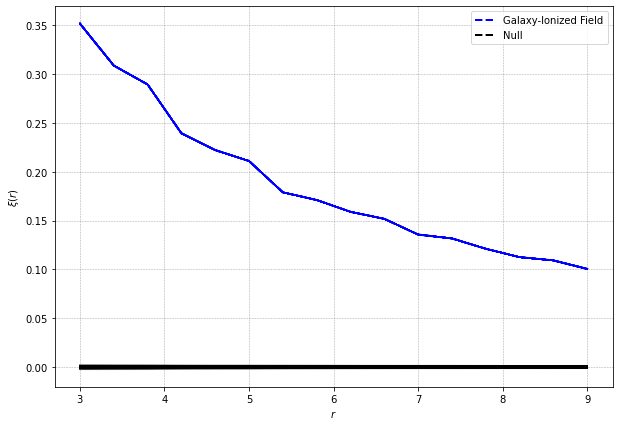

In [5]:
# Plotting for 2-point cross correlation
plt.figure(figsize=(10, 7))
for i in range(n_data):
    plt.plot(bins_xi,xi[i],color='b',alpha=0.1)
for i in range(n_null):    
    plt.plot(bins_xi,xi_null[i],color='k',alpha=0.1)
plt.plot(bins_xi, np.mean(xi, axis=0), color='b', ls='dashed',label='Galaxy-Ionized Field',lw=2) 
plt.plot(bins_xi, np.mean(xi_null, axis=0), color='k', ls='dashed',label='Null',lw=2) 

plt.ylabel(r'$\xi(r)$')
plt.xlabel(r'$r$')
plt.legend()
# plt.yscale('log')
plt.grid(True)  
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

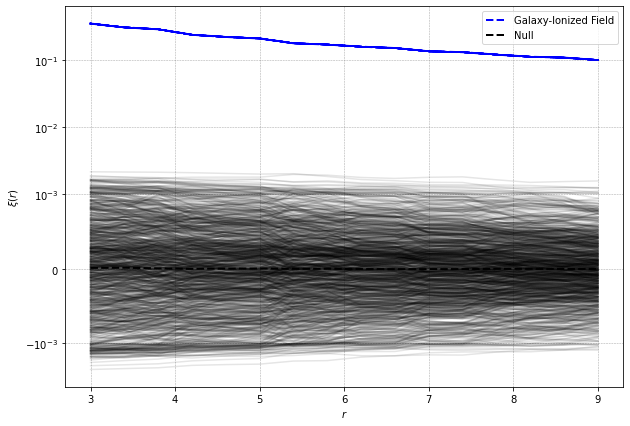

In [6]:
plt.figure(figsize=(10, 7))

for i in range(n_data):
    plt.plot(bins_xi, xi[i], color='b', alpha=0.1)
for i in range(n_null):    
    plt.plot(bins_xi, xi_null[i], color='k', alpha=0.1)

plt.plot(bins_xi, np.mean(xi, axis=0), color='b', ls='dashed', label='Galaxy-Ionized Field', lw=2) 
plt.plot(bins_xi, np.mean(xi_null, axis=0), color='k', ls='dashed', label='Null', lw=2) 

plt.ylabel(r'$\xi(r)$')
plt.xlabel(r'$r$')
plt.legend()

plt.yscale('symlog', linthresh=1e-3)  # log-like but safe for values near 0
plt.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

In [7]:
null = xi_null
cov_2pt = np.cov(null,rowvar=False,bias=True)
hartlap = (n_null-bin_len-2)/(n_null-1)
c_inv_2pt = hartlap*np.linalg.inv(cov_2pt)

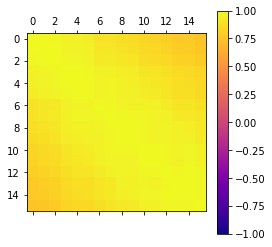

In [8]:
corr = np.corrcoef(null,rowvar=False)
plt.matshow(corr,vmax=1,vmin=-1,cmap='plasma')
plt.colorbar()

In [9]:
data_2pt = np.mean(xi, axis=0)
null_2pt = np.mean(xi_null, axis=0)

chi_sq_2pt = (np.transpose(data_2pt - null_2pt)).dot(c_inv_2pt).dot(data_2pt - null_2pt)
chi_sq_2pt_null = np.zeros(n_null)


for i in range(n_null):
    chi_sq_2pt_null[i] = (np.transpose(xi_null[i] - null_2pt)).dot(c_inv_2pt).dot(xi_null[i] - null_2pt)

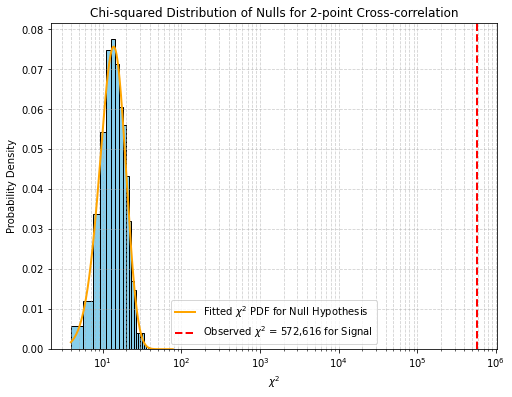

In [10]:
plt.figure(figsize=(8, 6))

# Fit chi-squared distribution with fixed degrees of freedom and location
dof = bin_len
_, loc_fit, scale_fit = chi2.fit(chi_sq_2pt_null, floc=0, f0=dof)

# Histogram of null values
plt.hist(chi_sq_2pt_null, bins=20, color='skyblue', edgecolor='black', density=True)

# Fitted chi-squared PDF
x_vals = np.logspace(np.log10(min(chi_sq_2pt_null)), 
                     np.log10(max(chi_sq_2pt_null)*2), 300)
plt.plot(x_vals, chi2.pdf(x_vals, dof, loc=loc_fit, scale=scale_fit), 
         color='orange', lw=2, label='Fitted $\chi^2$ PDF for Null Hypothesis')

# Vertical line for observed chi-sq value
plt.axvline(chi_sq_2pt, color='red', linestyle='--', linewidth=2, 
            label=f'Observed $\chi^2$ = {chi_sq_2pt:,.0f} for Signal')


plt.xscale('log')
plt.xlabel(r'$\chi^2$')
plt.ylabel('Probability Density')
plt.title('Chi-squared Distribution of Nulls for 2-point Cross-correlation')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.6)

plt.show()

In [11]:
chi_sq_2pt

572615.823173523

In [12]:
chi_sq_2pt_null

array([19.78808632, 14.88721643, 11.7435719 , 15.69060464, 16.70232837,
       10.57475235, 22.07052854, 16.71330467, 22.28917955, 12.97088908,
       26.46602728, 19.35469416,  6.49100084, 16.79746138, 11.58167867,
       16.857315  , 21.13582231, 11.54481301, 19.60921299, 12.48696108,
       13.16629631, 21.06927624, 10.88248363, 20.68789047, 16.48844866,
       18.24430337, 13.42523718, 11.37704167, 14.08700589, 12.95682487,
       11.11693123, 11.62831943, 19.83299924,  5.21182314, 20.33154897,
       14.16176969, 13.64903017, 11.37909318,  7.46406587, 15.30776355,
       17.01978662,  9.15464314, 19.2880634 ,  9.78476291,  8.90939691,
       16.52948702, 20.99868014, 15.26344822, 15.41691958, 18.64044993,
       17.08611085, 15.19138606, 25.98135891, 22.66317474, 10.15193766,
       20.79624855, 12.74325455, 19.67517306, 30.78129125, 11.18497909,
       20.94978282, 11.75302206, 26.09036292, 15.87771282, 13.12099169,
       19.43714053, 13.66895332, 16.16456096, 17.11281211, 14.24